# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [113]:
# import libraries
import pandas as pd
import pyspark
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
import pyspark.sql.functions as F
from pyspark.sql.functions import avg, col, concat, count, desc, explode, lit, min, max, split, stddev, udf
from pyspark.sql import Window

from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import re
import os
import datetime


In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("sparkify") \
    .getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '33333'),
 ('spark.app.name', 'sparkify'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', 'b9a1706a3fb8'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.id', 'local-1574033233346')]

In [4]:
spark

# 1. Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

### 1.1 Load Dataset

In [5]:
### 
#   Run the following cell.
#   This cell loads a function that prints the first n lines of
#   a file.
#
#   Then this function is called on the JSON file to print out
#   the first line of the population_data.json file
###

def print_lines(n, file_name):
    f = open(file_name)
    for i in range(n):
        print(f.readline())
    f.close()
    
print_lines(3, 'mini_sparkify_event_data.json')

{"ts":1538352117000,"userId":"30","sessionId":29,"page":"NextSong","auth":"Logged In","method":"PUT","status":200,"level":"paid","itemInSession":50,"location":"Bakersfield, CA","userAgent":"Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0","lastName":"Freeman","firstName":"Colin","registration":1538173362000,"gender":"M","artist":"Martha Tilston","song":"Rockpools","length":277.89016}

{"ts":1538352180000,"userId":"9","sessionId":8,"page":"NextSong","auth":"Logged In","method":"PUT","status":200,"level":"free","itemInSession":79,"location":"Boston-Cambridge-Newton, MA-NH","userAgent":"\"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36\"","lastName":"Long","firstName":"Micah","registration":1538331630000,"gender":"M","artist":"Five Iron Frenzy","song":"Canada","length":236.09424}

{"ts":1538352394000,"userId":"30","sessionId":29,"page":"NextSong","auth":"Logged In","method":"PUT","status":200,"level":"p

In [6]:
path = "mini_sparkify_event_data.json"
sparkify_log = spark.read.json(path)

In [7]:
# data type and the column names
sparkify_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
#sparkify_log.describe().show()

In [9]:
sparkify_log.describe('artist').show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



In [10]:
sparkify_log.describe("sessionId").show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [11]:
# the record number
sparkify_log.count()

286500

In [12]:
sparkify_log.select("auth").dropDuplicates().sort("auth").show()

+----------+
|      auth|
+----------+
| Cancelled|
|     Guest|
| Logged In|
|Logged Out|
+----------+



In [13]:
sparkify_log.select("length").dropDuplicates().sort("length").show()

+--------+
|  length|
+--------+
|    null|
| 0.78322|
| 2.16771|
| 4.04853|
|  4.8322|
|  6.3473|
| 7.83628|
| 8.30649|
| 9.01179|
|10.03057|
|10.52689|
|11.20608|
|11.25832|
|11.36281|
|11.49342|
|11.54567|
|11.93751|
|11.98975|
|12.22485|
|12.30322|
+--------+
only showing top 20 rows



In [14]:
sparkify_log.select("sessionId").dropDuplicates().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [15]:
# list all possible pages
sparkify_log.select("page").dropDuplicates().sort("page").show(40)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



### 1.2 Clean Dataset

In [16]:
# clean data
# clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids.
sparkify_log_valid = sparkify_log.dropna(how = "any", subset = ["userId", "sessionId", 'ts'])

In [17]:
sparkify_log_valid.count()

286500

In [18]:
# Looking for unique id of users
# Empty string at the first row
sparkify_log_valid.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [19]:
# session id looks alright
sparkify_log_valid.select("sessionId").dropDuplicates().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [20]:
sparkify_log_valid.select("level").dropDuplicates().sort("level").show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [21]:
# select only user id  is not empty
sparkify_log_valid = sparkify_log_valid.filter(sparkify_log_valid["userId"] != "")

In [22]:
# the total number of records after removing empty userid/sessionid records
sparkify_log_valid.count()

278154

In [23]:
# removing all records with null values
#sparkify_log_valid = sparkify_log_valid.na.drop()

In [24]:
#sparkify_log_valid.count()

It turns out there are no missing values in the userID or session columns. But there are userID values that are empty strings. 

Removing empty user ids/ session ids, 286500 -> 286500

Removing rows with empty userid, 286500 -> 278154

Removing all rows with empty values, 278154 -> 228108

# 2 . Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

All features:

- artist: string (nullable = true) -> artist name
- auth: string (nullable = true) -> cancelled/guest/loggedin/loggedout
- firstName: string (nullable = true) -> user name
- gender: string (nullable = true) -> user gender
- itemInSession: long (nullable = true) -> log count in a given session
- lastName: string (nullable = true) -> user name
- length: double (nullable = true) -> song's length in seconds
- level: string (nullable = true) -> subscription level; 2 categories (free and paid)
- location: string (nullable = true) -> user location
- method: string (nullable = true) -> http request method; 2 categories (GET and PUT)
- page: string (nullable = true) -> type of interaction (page accessed in the music streaming app); 22 categories (NextSong, Home, Login, Cancellation Confirmation, etc.)
- registration: long (nullable = true) -> user's registration timestamp
- sessionId: long (nullable = true) -> session to which the log belongs to
- song: string (nullable = true) -> song name
- status: long (nullable = true) -> http status code; 3 categories (200, 307 and 404)
- ts: long (nullable = true) -> (bigint) timestamp of a given log
- userAgent: string (nullable = true) -> browser or tool for using service
- userId: string (nullable = true) -> user identifier

Selected features:

Categorical features:
- artist
- auth
- gender
- level
- location
- page
- sessionId
- song
- userId

Numerical features:
- itemInSession
- length
- registration
- ts

### 2.1 Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [25]:
# selecting only part of the data set
"""
 |-- artist: string (nullable = true) -> artist name
 |-- auth: string (nullable = true) -> cancelled/guest/loggedin/loggedout
 |-- firstName: string (nullable = true) -> user name
 |-- gender: string (nullable = true) -> user gender
 |-- itemInSession: long (nullable = true) -> log count in a given session
 |-- lastName: string (nullable = true) -> user name
 |-- length: double (nullable = true) -> song's length in seconds
 |-- level: string (nullable = true) -> subscription level; 2 categories (free and paid)
 |-- location: string (nullable = true) -> user location
 |-- method: string (nullable = true) -> http request method; 2 categories (GET and PUT)
 |-- page: string (nullable = true) -> type of interaction (page accessed in the music streaming app); 22 categories (NextSong, Home, Login, Cancellation Confirmation, etc.)
 |-- registration: long (nullable = true) -> user's registration timestamp
 |-- sessionId: long (nullable = true) -> session to which the log belongs to
 |-- song: string (nullable = true) -> song name
 |-- status: long (nullable = true) -> http status code; 3 categories (200, 307 and 404)
 |-- ts: long (nullable = true) -> (bigint) timestamp of a given log
 |-- userAgent: string (nullable = true) -> browser or tool for using service
 |-- userId: string (nullable = true) -> user identifier
"""
sparkify_df = sparkify_log_valid.select(
    'artist','auth','gender','itemInSession', 'length', 'level',
    'location', 'page', 'sessionId', 'song', 'userId', 'ts', 'registration'
)

In [26]:
# data type and the column names
sparkify_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- page: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- registration: long (nullable = true)



In [27]:
#  create a column Churn to use as the label for your model. - Cancellation Confirmation
#sparkify_df.Churn
flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
sparkify_df_churn = sparkify_df.withColumn("Churn", flag_cancellation_event("page"))

In [28]:
# data type and the column names
sparkify_df_churn.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- page: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- registration: long (nullable = true)
 |-- Churn: integer (nullable = true)



In [29]:
# drop duplicates
sparkify_df_churn.dropDuplicates()
sparkify_df_churn.select("Churn").dropDuplicates().sort("Churn").show()

+-----+
|Churn|
+-----+
|    0|
|    1|
+-----+



###  2.2 Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### 2.2.1 Calculating Statistics by Hour

In [30]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [31]:
sparkify_df_churn.select("ts").dropDuplicates().sort("ts").show()

+-------------+
|           ts|
+-------------+
|1538352117000|
|1538352180000|
|1538352394000|
|1538352416000|
|1538352676000|
|1538352678000|
|1538352886000|
|1538352899000|
|1538352905000|
|1538353084000|
|1538353146000|
|1538353150000|
|1538353218000|
|1538353375000|
|1538353376000|
|1538353441000|
|1538353576000|
|1538353668000|
|1538353687000|
|1538353744000|
+-------------+
only showing top 20 rows



In [32]:
sparkify_df_hour = sparkify_df_churn.withColumn("hour", get_hour(sparkify_df_churn.ts))

In [33]:
sparkify_df_hour.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- page: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- registration: long (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- hour: string (nullable = true)



In [34]:
sparkify_df_hour.head()

Row(artist='Martha Tilston', auth='Logged In', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', page='NextSong', sessionId=29, song='Rockpools', userId='30', ts=1538352117000, registration=1538173362000, Churn=0, hour='0')

In [35]:
songs_in_hour = sparkify_df_hour.filter(sparkify_df_hour.page == "NextSong").groupby(sparkify_df_hour.hour).count().orderBy(sparkify_df_hour.hour.cast("float"))
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0| 9062|
|   1| 8388|
|   2| 8336|
|   3| 8355|
|   4| 8147|
|   5| 8178|
|   6| 8054|
|   7| 8091|
|   8| 8253|
|   9| 8498|
|  10| 8882|
|  11| 8830|
|  12| 9326|
|  13| 9644|
|  14|10494|
|  15|11354|
|  16|11636|
|  17|11460|
|  18|11124|
|  19|10930|
+----+-----+
only showing top 20 rows



In [36]:
songs_hour_cancel = sparkify_df_hour.filter(sparkify_df_hour.page == "Cancellation Confirmation").groupby(sparkify_df_hour.hour).count().orderBy(sparkify_df_hour.hour.cast("float"))
songs_hour_cancel.show()

+----+-----+
|hour|count|
+----+-----+
|   0|    3|
|   1|    1|
|   2|    1|
|   3|    2|
|   4|    2|
|   5|    1|
|   7|    6|
|   8|    1|
|  10|    1|
|  11|    2|
|  12|    2|
|  13|    1|
|  14|    1|
|  15|    4|
|  16|    4|
|  17|    2|
|  18|    3|
|  19|    5|
|  20|    3|
|  21|    3|
+----+-----+
only showing top 20 rows



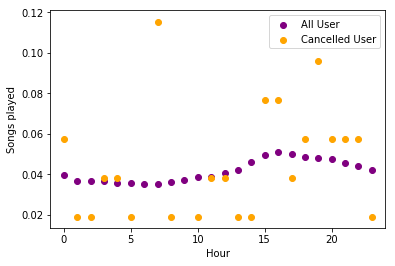

In [37]:
# all song play hour 
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

# service cancelation hour
songs_hour_cancel_pd = songs_hour_cancel.toPandas()
songs_hour_cancel_pd.hour = pd.to_numeric(songs_hour_cancel_pd.hour)

# plotting
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"]/songs_in_hour_pd["count"].sum(), c="purple", label="All User")
plt.scatter(songs_hour_cancel_pd["hour"], songs_hour_cancel_pd["count"]/songs_hour_cancel_pd["count"].sum(), c = "orange", label="Cancelled User")
plt.xlim(-1, 24)
plt.legend()
plt.xlabel("Hour")
plt.ylabel("Songs played");

Thus the cancelation is mostly happend in morning around 7 am and in evening around 19 pm.  

# 3. Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### 3.1 Project Goal
The goal for this project is to understand the main features that contribute to user service cancellation, and potentially provide suggestion for improving user service experience. I'd like to understand following questions:

- How long does it take for user to cancel the service?
- What are the top songs paid user like?
- What is the main factor that contribute to a free user subscribing the service?
- What is the main factor that contribute to a paid user cancel service?


### 3.2 How long does it take for user to cancel the service?

In [38]:
# create data frame containing time info
cancel_period_df = sparkify_df_hour.filter(sparkify_df_hour.page == "Cancellation Confirmation").select('userId', 'registration', 'ts', 'page')
cancel_period_df.show(5)

+------+-------------+-------------+--------------------+
|userId| registration|           ts|                page|
+------+-------------+-------------+--------------------+
|    18|1535623466000|1538943990000|Cancellation Conf...|
|    32|1537167593000|1539033046000|Cancellation Conf...|
|   125|1533157139000|1539318918000|Cancellation Conf...|
|   105|1536817381000|1539375441000|Cancellation Conf...|
|    17|1538333829000|1539465584000|Cancellation Conf...|
+------+-------------+-------------+--------------------+
only showing top 5 rows



In [39]:
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).isoformat())

In [40]:
cancel_period_df_date = cancel_period_df.withColumn("re_date", get_date(cancel_period_df.registration))
cancel_period_df_date = cancel_period_df_date.withColumn("can_date", get_date(cancel_period_df_date.ts))
cancel_period_df_date.show(5)

+------+-------------+-------------+--------------------+-------------------+-------------------+
|userId| registration|           ts|                page|            re_date|           can_date|
+------+-------------+-------------+--------------------+-------------------+-------------------+
|    18|1535623466000|1538943990000|Cancellation Conf...|2018-08-30T10:04:26|2018-10-07T20:26:30|
|    32|1537167593000|1539033046000|Cancellation Conf...|2018-09-17T06:59:53|2018-10-08T21:10:46|
|   125|1533157139000|1539318918000|Cancellation Conf...|2018-08-01T20:58:59|2018-10-12T04:35:18|
|   105|1536817381000|1539375441000|Cancellation Conf...|2018-09-13T05:43:01|2018-10-12T20:17:21|
|    17|1538333829000|1539465584000|Cancellation Conf...|2018-09-30T18:57:09|2018-10-13T21:19:44|
+------+-------------+-------------+--------------------+-------------------+-------------------+
only showing top 5 rows



In [41]:
cancel_period_df_date = cancel_period_df_date.withColumn(
    "date_diff", 
    F.datediff(F.col('can_date'), F.col('re_date'))
)
cancel_period_df_date.show(5, truncate=False)

+------+-------------+-------------+-------------------------+-------------------+-------------------+---------+
|userId|registration |ts           |page                     |re_date            |can_date           |date_diff|
+------+-------------+-------------+-------------------------+-------------------+-------------------+---------+
|18    |1535623466000|1538943990000|Cancellation Confirmation|2018-08-30T10:04:26|2018-10-07T20:26:30|38       |
|32    |1537167593000|1539033046000|Cancellation Confirmation|2018-09-17T06:59:53|2018-10-08T21:10:46|21       |
|125   |1533157139000|1539318918000|Cancellation Confirmation|2018-08-01T20:58:59|2018-10-12T04:35:18|72       |
|105   |1536817381000|1539375441000|Cancellation Confirmation|2018-09-13T05:43:01|2018-10-12T20:17:21|29       |
|17    |1538333829000|1539465584000|Cancellation Confirmation|2018-09-30T18:57:09|2018-10-13T21:19:44|13       |
+------+-------------+-------------+-------------------------+-------------------+--------------

In [42]:
cancel_period_pd = cancel_period_df_date.toPandas()
cancel_period_pd.date_diff = pd.to_numeric(cancel_period_pd.date_diff)
cancel_period_pd.head(5)

,userId,registration,ts,page,re_date,can_date,date_diff
0,18,1535623466000,1538943990000,Cancellation Confirmation,2018-08-30T10:04:26,2018-10-07T20:26:30,38
1,32,1537167593000,1539033046000,Cancellation Confirmation,2018-09-17T06:59:53,2018-10-08T21:10:46,21
2,125,1533157139000,1539318918000,Cancellation Confirmation,2018-08-01T20:58:59,2018-10-12T04:35:18,72
3,105,1536817381000,1539375441000,Cancellation Confirmation,2018-09-13T05:43:01,2018-10-12T20:17:21,29
4,17,1538333829000,1539465584000,Cancellation Confirmation,2018-09-30T18:57:09,2018-10-13T21:19:44,13


In [43]:
cancel_period_pd.date_diff.describe()

count     52.000000
mean      57.365385
std       36.587809
min        5.000000
25%       30.500000
50%       51.500000
75%       73.750000
max      188.000000
Name: date_diff, dtype: float64

Text(0,0.5,'Counts')

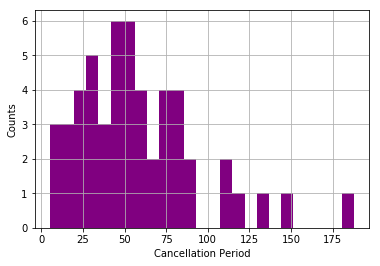

In [44]:
cancel_period_pd.date_diff.hist(bins =25, color ='purple')
plt.xlabel("Cancellation Period")
plt.ylabel("Counts")

The average time interval for a user to subscribe and then cancel is 57 days. Most unsubscription happens around 50 days. Only few user unsubscribe after 188 days. 

### 3.3 What are the top songs paid user like?

In [45]:
# create data frame containing song info
topsong_df = sparkify_df_hour.filter(sparkify_df_hour.level == "paid").select('userId', 'song')
topsong_df.show(5)

+------+--------------------+
|userId|                song|
+------+--------------------+
|    30|           Rockpools|
|    30|   Time For Miracles|
|    30|Harder Better Fas...|
|    30|Passengers (Old A...|
|    30|                null|
+------+--------------------+
only showing top 5 rows



In [46]:
sparkify_df_hour.filter(sparkify_df_hour.level == "paid").groupby(sparkify_df_hour.song).count().orderBy('count', ascending = False).show()

+--------------------+-----+
|                song|count|
+--------------------+-----+
|                null|36316|
|      You're The One|  915|
|                Undo|  842|
|             Revelry|  686|
|       Sehr kosmisch|  597|
|Horn Concerto No....|  521|
|Dog Days Are Over...|  445|
|        Use Somebody|  377|
|             Secrets|  374|
|             Invalid|  353|
|              Canada|  349|
|    Ain't Misbehavin|  329|
|       ReprÃÂ©sente|  317|
|Catch You Baby (S...|  311|
|SinceritÃÂ© Et J...|  309|
|              Yellow|  292|
|    Somebody To Love|  280|
|            The Gift|  271|
|    Hey_ Soul Sister|  269|
|            Tive Sim|  259|
+--------------------+-----+
only showing top 20 rows



Top songs subscribed user like are:
- You're The One
- Undo
- Revel

### 3.4 Feature engineering for modeling

Considering features that potentially contributing to a free user subscribing the service，including：

Each row is **userId**

Categorical features:
- 1. artist -> number of artist listened by the user
- 2. gender -> true categorical
- 4. page -> for types of activities, it is possible to count the frequency for each user
    - Add Friend
    - Add to Playlist
    - Error
    - Downgrade
    - Help
    - NextSong
    - Settings
    - Thumbs Down
    - Thumbs Up
    - Upgrade
- 5. sessionId -> converting to session numbers
- 6. song -> number of songs listened by the user

Thus my dependent vaiable y is **level**.
Goal: create model to predict level label (free/paid)

In [47]:
# starting point
sparkify_df_hour.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- page: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- registration: long (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- hour: string (nullable = true)



In [48]:
# 1. artist -> number of artist listened by the user
feature_artist = sparkify_df_hour.filter(sparkify_df_hour.page=="NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()
feature_artist = feature_artist.withColumnRenamed("count", "aritstCount")
feature_artist.show(3), feature_artist.count()

+------+-----------+
|userId|aritstCount|
+------+-----------+
|100010|        252|
|200002|        339|
|   125|          8|
+------+-----------+
only showing top 3 rows



(None, 225)

In [49]:
# 2. gender -> true categorical
feature_gender = sparkify_df_hour.select("userId", "gender").dropDuplicates()
feature_gender = feature_gender.replace(["M", "F"], ["0", "1"], "gender")
feature_gender = feature_gender.select("userId", feature_gender.gender.cast("int"))
feature_gender.show(3), feature_gender.count()

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
+------+------+
only showing top 3 rows



(None, 225)

In [50]:
# 4.1 - Add Friend
feature_page_addfriend = sparkify_df_hour.filter(sparkify_df_hour.page=="Add Friend").select("userId", "page").groupby("userId").count()
feature_page_addfriend = feature_page_addfriend.withColumnRenamed("count", "addfriendCount")
feature_page_addfriend.show(3), feature_page_addfriend.count()

+------+--------------+
|userId|addfriendCount|
+------+--------------+
|100010|             4|
|200002|             4|
|    51|            28|
+------+--------------+
only showing top 3 rows



(None, 206)

In [51]:
# 4.2 - Add to Playlist
feature_page_playlist = sparkify_df_hour.filter(sparkify_df_hour.page=="Add to Playlist").select("userId", "page").groupby("userId").count()
feature_page_playlist = feature_page_playlist.withColumnRenamed("count", "addplylistCount")
feature_page_playlist.show(3), feature_page_playlist.count()

+------+---------------+
|userId|addplylistCount|
+------+---------------+
|100010|              7|
|200002|              8|
|    51|             52|
+------+---------------+
only showing top 3 rows



(None, 215)

In [52]:
# 4.3 - Error
feature_page_error = sparkify_df_hour.filter(sparkify_df_hour.page=="Error").select("userId", "page").groupby("userId").count()
feature_page_error = feature_page_error.withColumnRenamed("count", "errorCount")
feature_page_error.show(3), feature_page_error.count()

+------+----------+
|userId|errorCount|
+------+----------+
|   124|         6|
|    51|         1|
|     7|         1|
+------+----------+
only showing top 3 rows



(None, 117)

In [53]:
# 4.4 - Downgrade
feature_page_downgrade = sparkify_df_hour.filter(sparkify_df_hour.page=="Downgrade").select("userId", "page").groupby("userId").count()
feature_page_downgrade = feature_page_downgrade.withColumnRenamed("count", "downgradeCount")
feature_page_downgrade.show(3), feature_page_downgrade.count()

+------+--------------+
|userId|downgradeCount|
+------+--------------+
|200002|             5|
|    51|            23|
|   124|            41|
+------+--------------+
only showing top 3 rows



(None, 154)

In [54]:
# 4.5 - Help
feature_page_help = sparkify_df_hour.filter(sparkify_df_hour.page=="Help").select("userId", "page").groupby("userId").count()
feature_page_help = feature_page_help.withColumnRenamed("count", "helpCount")
feature_page_help.show(3), feature_page_help.count()

+------+---------+
|userId|helpCount|
+------+---------+
|100010|        2|
|200002|        2|
|    51|       12|
+------+---------+
only showing top 3 rows



(None, 192)

In [55]:
# 4.6 - NextSong
feature_page_NextSong = sparkify_df_hour.filter(sparkify_df_hour.page=="NextSong").select("userId", "page").groupby("userId").count()
feature_page_NextSong = feature_page_NextSong.withColumnRenamed("count", "NextSongCount")
feature_page_NextSong.show(3), feature_page_NextSong.count()

+------+-------------+
|userId|NextSongCount|
+------+-------------+
|100010|          275|
|200002|          387|
|   125|            8|
+------+-------------+
only showing top 3 rows



(None, 225)

In [56]:
# 4.7 - Settings
feature_page_Settings = sparkify_df_hour.filter(sparkify_df_hour.page=="Settings").select("userId", "page").groupby("userId").count()
feature_page_Settings = feature_page_Settings.withColumnRenamed("count", "SettingsCount")
feature_page_Settings.show(3), feature_page_Settings.count()

+------+-------------+
|userId|SettingsCount|
+------+-------------+
|200002|            3|
|    51|           12|
|   124|           20|
+------+-------------+
only showing top 3 rows



(None, 195)

In [57]:
# 4.8 - Thumbs Down
feature_page_ThumbDown = sparkify_df_hour.filter(sparkify_df_hour.page=="Thumbs Down").select("userId", "page").groupby("userId").count()
feature_page_ThumbDown = feature_page_ThumbDown.withColumnRenamed("count", "ThumbDownCount")
feature_page_ThumbDown.show(3), feature_page_ThumbDown.count()

+------+--------------+
|userId|ThumbDownCount|
+------+--------------+
|100010|             5|
|200002|             6|
|    51|            21|
+------+--------------+
only showing top 3 rows



(None, 203)

In [58]:
# 4.9 - Thumbs Up
feature_page_ThumbUp = sparkify_df_hour.filter(sparkify_df_hour.page=="Thumbs Up").select("userId", "page").groupby("userId").count()
feature_page_ThumbUp = feature_page_ThumbUp.withColumnRenamed("count", "ThumbUpCount")
feature_page_ThumbUp.show(3), feature_page_ThumbUp.count()

+------+------------+
|userId|ThumbUpCount|
+------+------------+
|100010|          17|
|200002|          21|
|    51|         100|
+------+------------+
only showing top 3 rows



(None, 220)

In [59]:
# 4.10 - Upgrade
feature_page_upgrade = sparkify_df_hour.filter(sparkify_df_hour.page=="Upgrade").select("userId", "page").groupby("userId").count()
feature_page_upgrade = feature_page_upgrade.withColumnRenamed("count", "upgradeCount")
feature_page_upgrade.show(3), feature_page_upgrade.count()

+------+------------+
|userId|upgradeCount|
+------+------------+
|100010|           2|
|200002|           2|
|     7|           2|
+------+------------+
only showing top 3 rows



(None, 168)

In [60]:
# 5. sessionId -> converting to session numbers
feature_sessions = sparkify_df_hour.select("userId", "sessionId").groupby("userId").count()
feature_sessions = feature_sessions.withColumnRenamed("count", "sessionsCount")
feature_sessions.show(3), feature_sessions.count()

+------+-------------+
|userId|sessionsCount|
+------+-------------+
|100010|          381|
|200002|          474|
|   125|           11|
+------+-------------+
only showing top 3 rows



(None, 225)

In [61]:
# 6. song -> number of songs listened by the user
feature_songs = sparkify_df_hour.select("userId", "song").groupby("userId").count()
feature_songs = feature_songs.withColumnRenamed("count", "songsCount")
feature_songs.show(3), feature_songs.count()

+------+----------+
|userId|songsCount|
+------+----------+
|100010|       381|
|200002|       474|
|   125|        11|
+------+----------+
only showing top 3 rows



(None, 225)

In [62]:
# label: level
# notice the way for match values
label_level = sparkify_df_hour.select("userId", "level", "ts").dropDuplicates()
label_level = label_level.replace(["free", "paid"], ["0", "1"], "level")
label_level = label_level.select("userId", label_level.level.cast("int"), "ts")

w = Window.partitionBy('userId')
label_level = label_level.withColumn('maxts', F.max('ts').over(w))\
                .where(F.col('ts') == F.col('maxts'))\
                .drop('maxts')\

label_level.show(3), label_level.count()

+------+-----+-------------+
|userId|level|           ts|
+------+-----+-------------+
|100010|    0|1542823952000|
|200002|    1|1542324354000|
|   125|    0|1539318918000|
+------+-----+-------------+
only showing top 3 rows



(None, 225)

In [63]:
# label: cancellation
label_churn = sparkify_df_hour.select("userId", "page").filter(sparkify_df_hour.page=="Cancellation Confirmation").dropDuplicates()
label_churn = label_churn.replace(['Cancellation Confirmation'],['1'], 'page')
label_churn = label_churn.select('userId', label_churn.page.cast('int'))

label_churn.show(3), label_churn.count()

+------+----+
|userId|page|
+------+----+
|100025|   1|
|    18|   1|
|   122|   1|
+------+----+
only showing top 3 rows



(None, 52)

In [64]:
# Combining features
features_all = [
    feature_artist,
    feature_gender,
    feature_page_addfriend,
    feature_page_playlist,
    feature_page_error,
    feature_page_downgrade,
    feature_page_help,
    feature_page_Settings,
    feature_page_ThumbDown,
    feature_page_ThumbUp,
    feature_page_upgrade,
    feature_sessions,
    feature_songs
]

In [65]:
# prepare the final dataframe to join all the other features
features_all_df = sparkify_df_hour.select("userId").dropDuplicates()

for feature in features_all:
    features_all_df = features_all_df.join(feature, on =['userId'], how='left')

features_all_df.show(5), features_all_df.printSchema()

+------+-----------+------+--------------+---------------+----------+--------------+---------+-------------+--------------+------------+------------+-------------+----------+
|userId|aritstCount|gender|addfriendCount|addplylistCount|errorCount|downgradeCount|helpCount|SettingsCount|ThumbDownCount|ThumbUpCount|upgradeCount|sessionsCount|songsCount|
+------+-----------+------+--------------+---------------+----------+--------------+---------+-------------+--------------+------------+------------+-------------+----------+
|100010|        252|     1|             4|              7|      null|          null|        2|         null|             5|          17|           2|          381|       381|
|200002|        339|     0|             4|              8|      null|             5|        2|            3|             6|          21|           2|          474|       474|
|   125|          8|     0|          null|           null|      null|          null|     null|         null|          null|  

(None, None)

In [66]:
features_all_df = features_all_df.na.fill(0)
features_all_df.show(3), features_all_df.count()

+------+-----------+------+--------------+---------------+----------+--------------+---------+-------------+--------------+------------+------------+-------------+----------+
|userId|aritstCount|gender|addfriendCount|addplylistCount|errorCount|downgradeCount|helpCount|SettingsCount|ThumbDownCount|ThumbUpCount|upgradeCount|sessionsCount|songsCount|
+------+-----------+------+--------------+---------------+----------+--------------+---------+-------------+--------------+------------+------------+-------------+----------+
|100010|        252|     1|             4|              7|         0|             0|        2|            0|             5|          17|           2|          381|       381|
|200002|        339|     0|             4|              8|         0|             5|        2|            3|             6|          21|           2|          474|       474|
|   125|          8|     0|             0|              0|         0|             0|        0|            0|             0|  

(None, 225)

In [67]:
# create label data frame with the same user id
label_level_df = features_all_df.select('userId').join(label_level, on =['userId'], how='left')
label_level_df.show(3), label_level_df.printSchema(), label_level_df.count()

+------+-----+-------------+
|userId|level|           ts|
+------+-----+-------------+
|100010|    0|1542823952000|
|200002|    1|1542324354000|
|   125|    0|1539318918000|
+------+-----+-------------+
only showing top 3 rows

root
 |-- userId: string (nullable = true)
 |-- level: integer (nullable = true)
 |-- ts: long (nullable = true)



(None, None, 225)

In [68]:
# create label data frame with the same user id
label_churn_df = features_all_df.select('userId').join(label_churn, on =['userId'], how='left').na.fill(0)
label_churn_df.show(10), label_churn_df.printSchema(), label_churn_df.count()

+------+----+
|userId|page|
+------+----+
|100010|   0|
|200002|   0|
|   125|   1|
|   124|   0|
|    51|   1|
|     7|   0|
|    15|   0|
|    54|   1|
|   155|   0|
|100014|   1|
+------+----+
only showing top 10 rows

root
 |-- userId: string (nullable = true)
 |-- page: integer (nullable = true)



(None, None, 225)

In [69]:
features_all_df.columns[1:]

['aritstCount',
 'gender',
 'addfriendCount',
 'addplylistCount',
 'errorCount',
 'downgradeCount',
 'helpCount',
 'SettingsCount',
 'ThumbDownCount',
 'ThumbUpCount',
 'upgradeCount',
 'sessionsCount',
 'songsCount']

Except gender and location, all other columns can be easily cast to numberic.

# 4. Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### 4.1 What is the main factor that contribute to a free user subscribing the service?

In [70]:
# create vector
assembler = VectorAssembler(inputCols=features_all_df.columns[1:], outputCol="NumFeatures")
data = assembler.transform(features_all_df)
data.count()

225

In [71]:
data.printSchema()

root
 |-- userId: string (nullable = true)
 |-- aritstCount: long (nullable = true)
 |-- gender: integer (nullable = true)
 |-- addfriendCount: long (nullable = true)
 |-- addplylistCount: long (nullable = true)
 |-- errorCount: long (nullable = true)
 |-- downgradeCount: long (nullable = true)
 |-- helpCount: long (nullable = true)
 |-- SettingsCount: long (nullable = true)
 |-- ThumbDownCount: long (nullable = true)
 |-- ThumbUpCount: long (nullable = true)
 |-- upgradeCount: long (nullable = true)
 |-- sessionsCount: long (nullable = true)
 |-- songsCount: long (nullable = true)
 |-- NumFeatures: vector (nullable = true)



In [72]:
data.head(5)

[Row(userId='100010', aritstCount=252, gender=1, addfriendCount=4, addplylistCount=7, errorCount=0, downgradeCount=0, helpCount=2, SettingsCount=0, ThumbDownCount=5, ThumbUpCount=17, upgradeCount=2, sessionsCount=381, songsCount=381, NumFeatures=DenseVector([252.0, 1.0, 4.0, 7.0, 0.0, 0.0, 2.0, 0.0, 5.0, 17.0, 2.0, 381.0, 381.0])),
 Row(userId='200002', aritstCount=339, gender=0, addfriendCount=4, addplylistCount=8, errorCount=0, downgradeCount=5, helpCount=2, SettingsCount=3, ThumbDownCount=6, ThumbUpCount=21, upgradeCount=2, sessionsCount=474, songsCount=474, NumFeatures=DenseVector([339.0, 0.0, 4.0, 8.0, 0.0, 5.0, 2.0, 3.0, 6.0, 21.0, 2.0, 474.0, 474.0])),
 Row(userId='125', aritstCount=8, gender=0, addfriendCount=0, addplylistCount=0, errorCount=0, downgradeCount=0, helpCount=0, SettingsCount=0, ThumbDownCount=0, ThumbUpCount=0, upgradeCount=0, sessionsCount=11, songsCount=11, NumFeatures=SparseVector(13, {0: 8.0, 11: 11.0, 12: 11.0})),
 Row(userId='124', aritstCount=2232, gender=1

In [73]:
# scale the data
scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [74]:
data.show(5)

+------+-----------+------+--------------+---------------+----------+--------------+---------+-------------+--------------+------------+------------+-------------+----------+--------------------+--------------------+
|userId|aritstCount|gender|addfriendCount|addplylistCount|errorCount|downgradeCount|helpCount|SettingsCount|ThumbDownCount|ThumbUpCount|upgradeCount|sessionsCount|songsCount|         NumFeatures|   ScaledNumFeatures|
+------+-----------+------+--------------+---------------+----------+--------------+---------+-------------+--------------+------------+------------+-------------+----------+--------------------+--------------------+
|100010|        252|     1|             4|              7|         0|             0|        2|            0|             5|          17|           2|          381|       381|[252.0,1.0,4.0,7....|[0.41725179202960...|
|200002|        339|     0|             4|              8|         0|             5|        2|            3|             6|         

In [75]:
data.printSchema(), data.count(),

root
 |-- userId: string (nullable = true)
 |-- aritstCount: long (nullable = true)
 |-- gender: integer (nullable = true)
 |-- addfriendCount: long (nullable = true)
 |-- addplylistCount: long (nullable = true)
 |-- errorCount: long (nullable = true)
 |-- downgradeCount: long (nullable = true)
 |-- helpCount: long (nullable = true)
 |-- SettingsCount: long (nullable = true)
 |-- ThumbDownCount: long (nullable = true)
 |-- ThumbUpCount: long (nullable = true)
 |-- upgradeCount: long (nullable = true)
 |-- sessionsCount: long (nullable = true)
 |-- songsCount: long (nullable = true)
 |-- NumFeatures: vector (nullable = true)
 |-- ScaledNumFeatures: vector (nullable = true)



(None, 225)

In [76]:
dataset = label_level_df.select('userId', 'level').join(data.select('userId', 'ScaledNumFeatures'), on='userId', how='left')
dataset = dataset.select(col("level").alias("label"), col("ScaledNumFeatures").alias("features"))

In [77]:
dataset.head(5)

[Row(label=0, features=DenseVector([0.4173, 2.0013, 0.1943, 0.214, 0.0, 0.0, 0.2761, 0.0, 0.3823, 0.2596, 0.7817, 0.2866, 0.2866])),
 Row(label=1, features=DenseVector([0.5613, 0.0, 0.1943, 0.2445, 0.0, 0.4261, 0.2761, 0.4296, 0.4588, 0.3207, 0.7817, 0.3565, 0.3565])),
 Row(label=0, features=SparseVector(13, {0: 0.0132, 11: 0.0083, 12: 0.0083})),
 Row(label=1, features=DenseVector([3.6957, 2.0013, 3.5954, 3.6067, 4.0744, 3.494, 3.1757, 2.8639, 3.1352, 2.6116, 0.0, 3.6291, 3.6291])),
 Row(label=1, features=DenseVector([2.2932, 0.0, 1.3604, 1.5894, 0.6791, 1.96, 1.6569, 1.7183, 1.6058, 1.5272, 0.0, 1.8533, 1.8533]))]

In [78]:
dataset.show(3), dataset.printSchema(), dataset.count()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.41725179202960...|
|    1|[0.56130300594458...|
|    0|(13,[0,11,12],[0....|
+-----+--------------------+
only showing top 3 rows

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)



(None, None, 225)

In [79]:
# split train, test set
train, validation = dataset.randomSplit([0.8, 0.2], seed=123)

#### 4.1.1 Lasso linear model

In [80]:
# linear regression 
lr = LinearRegression(maxIter=5, regParam=0.0, elasticNetParam=1.0 , fitIntercept=False, \
                      solver="auto")

In [81]:
lrModel_level = lr.fit(train)
lrModel_level.write().overwrite().save('lrModel_level.model')

In [82]:
lrModel_level.summary.r2

0.787324980047107

In [83]:
lrModel_level.coefficients

DenseVector([1.7994, 0.0169, 0.3405, -0.0117, -0.0011, 0.2, -0.0627, -0.0231, -0.0704, 0.2596, 0.0284, -1.63, -0.5994])

In [84]:
features_all_df.columns[1:]

['aritstCount',
 'gender',
 'addfriendCount',
 'addplylistCount',
 'errorCount',
 'downgradeCount',
 'helpCount',
 'SettingsCount',
 'ThumbDownCount',
 'ThumbUpCount',
 'upgradeCount',
 'sessionsCount',
 'songsCount']

In [85]:
lrModel_level_coef_pd = pd.DataFrame({"feature": features_all_df.columns[1:], "coef":lrModel_level.coefficients})
lrModel_level_coef_pd.sort_values('coef', ascending=False)

,feature,coef
0,aritstCount,1.799450
2,addfriendCount,0.340525
9,ThumbUpCount,0.259553
5,downgradeCount,0.199955
10,upgradeCount,0.028441
1,gender,0.016902
4,errorCount,-0.001053
3,addplylistCount,-0.011718
7,SettingsCount,-0.023103
6,helpCount,-0.062746


In [112]:
# testing set
test_predict = lrModel_level.transform(validation)
test_predict.show(3)

+-----+--------------------+-------------------+
|label|            features|         prediction|
+-----+--------------------+-------------------+
|    1|[0.56130300594458...| 0.4096640089078738|
|    0|[0.23511807328652...|0.12608678886093583|
|    1|[2.05479949963784...| 1.0568398872605458|
+-----+--------------------+-------------------+
only showing top 3 rows



In [123]:
# round prediction to 0 and 1
get_pred = udf(lambda x: 1 if x >= 0.5 else 0)
test_predict = test_predict.withColumn("predict_true", get_pred("prediction").cast('double'))
test_predict.show(3)

+-----+--------------------+-------------------+------------+
|label|            features|         prediction|predict_true|
+-----+--------------------+-------------------+------------+
|    1|[0.56130300594458...| 0.4096640089078738|         0.0|
|    0|[0.23511807328652...|0.12608678886093583|         0.0|
|    1|[2.05479949963784...| 1.0568398872605458|         1.0|
+-----+--------------------+-------------------+------------+
only showing top 3 rows



In [124]:
test_predict.printSchema()

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: double (nullable = false)
 |-- predict_true: double (nullable = true)



In [125]:
evaluator = MulticlassClassificationEvaluator(predictionCol="predict_true")

In [126]:
evaluator.evaluate(test_predict, {evaluator.metricName: "f1"})

0.7674621335948567

In [127]:
evaluator.evaluate(test_predict, {evaluator.metricName: "accuracy"})

0.7608695652173914

#### 4.1.1 GLM model

In [128]:
gl = GeneralizedLinearRegression(family="gaussian", link="identity", linkPredictionCol="p")

In [129]:
glModel_level = gl.fit(train)
glModel_level.write().overwrite().save('glModel_level.model')

In [130]:
glModel_level.summary

Coefficients:
    Feature Estimate    Std Error T Value P Value
(Intercept)   0.1792       0.0624  2.8710  0.0046
 features_0   1.4209       0.2265  6.2746  0.0000
 features_1  -0.0083       0.0287 -0.2880  0.7737
 features_2   0.3209       0.0943  3.4037  0.0008
 features_3   0.0455       0.1860  0.2450  0.8068
 features_4  -0.0085       0.0425 -0.1996  0.8421
 features_5   0.2436       0.0918  2.6538  0.0087
 features_6  -0.0660       0.0839 -0.7864  0.4328
 features_7  -0.0372       0.0785 -0.4734  0.6366
 features_8  -0.0855       0.0570 -1.5015  0.1351
 features_9   0.2674       0.1275  2.0971  0.0375
features_10   0.0128       0.0339  0.3785  0.7055
features_11  -1.3965 1545133.9326  0.0000  1.0000
features_12  -0.5130 1545133.9326  0.0000  1.0000

(Dispersion parameter for gaussian family taken to be 0.1399)
    Null deviance: 41.3966 on 165 degrees of freedom
Residual deviance: 23.0914 on 165 degrees of freedom
AIC: 171.4017

In [132]:
gl_test_pred = glModel_level.transform(validation)
gl_test_pred.show(3)

+-----+--------------------+-------------------+-------------------+
|label|            features|         prediction|                  p|
+-----+--------------------+-------------------+-------------------+
|    1|[0.56130300594458...| 0.4956579707593485| 0.4956579707593485|
|    0|[0.23511807328652...|0.24840180311241106|0.24840180311241106|
|    1|[2.05479949963784...|  1.083275700672967|  1.083275700672967|
+-----+--------------------+-------------------+-------------------+
only showing top 3 rows



In [133]:
# round prediction to 0 and 1
gl_test_pred = gl_test_pred.withColumn("predict_true", get_pred("prediction").cast('double'))
gl_test_pred.show(3)

+-----+--------------------+-------------------+-------------------+------------+
|label|            features|         prediction|                  p|predict_true|
+-----+--------------------+-------------------+-------------------+------------+
|    1|[0.56130300594458...| 0.4956579707593485| 0.4956579707593485|         0.0|
|    0|[0.23511807328652...|0.24840180311241106|0.24840180311241106|         0.0|
|    1|[2.05479949963784...|  1.083275700672967|  1.083275700672967|         1.0|
+-----+--------------------+-------------------+-------------------+------------+
only showing top 3 rows



In [136]:
glm_evaluator = MulticlassClassificationEvaluator(predictionCol="predict_true")

In [137]:
glm_evaluator.evaluate(gl_test_pred, {evaluator.metricName: "f1"})

0.808266898908019

In [138]:
glm_evaluator.evaluate(gl_test_pred, {evaluator.metricName: "accuracy"})

0.808266898908019

In [139]:
glm_evaluator.evaluate(gl_test_pred, {evaluator.metricName: "r2"})

0.808266898908019

### 4.2	What is the main factor that contribute to a paid user cancel service?

In [140]:
dataset2 = label_churn_df.select('userId', 'page').join(data.select('userId', 'ScaledNumFeatures'), on='userId', how='left')
dataset2 = dataset2.select(col("page").alias("label"), col("ScaledNumFeatures").alias("features"))

In [141]:
# split train, test set
train_cancel, validation_cancel = dataset2.randomSplit([0.8, 0.2], seed=123)

In [142]:
# linear regression 
lr_cancel = LinearRegression(maxIter=5, regParam=0.0, elasticNetParam=1.0 , fitIntercept=False, \
                      solver="auto")
lrModel_churn = lr_cancel.fit(train_cancel)
lrModel_churn.write().overwrite().save('lrModel_churn.model')

In [143]:
lrModel_churn.summary.r2

0.12648756657821092

In [144]:
lrModel_churn.coefficients

DenseVector([0.023, 0.0612, -0.0151, -0.0143, -0.0284, -0.001, -0.0009, 0.0262, 0.0194, -0.022, 0.0719, -0.0033, -0.0033])

In [145]:
lrModel_churn_coef_pd = pd.DataFrame({"feature": features_all_df.columns[1:], "coef":lrModel_churn.coefficients})
lrModel_churn_coef_pd.sort_values('coef', ascending=False)

,feature,coef
10,upgradeCount,0.071912
1,gender,0.061156
7,SettingsCount,0.026228
0,aritstCount,0.022952
8,ThumbDownCount,0.019421
6,helpCount,-0.000869
5,downgradeCount,-0.001043
11,sessionsCount,-0.003272
12,songsCount,-0.003272
3,addplylistCount,-0.014250


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.